In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

product_ids = ["BTC-USD", "ETH-USD"]

In [2]:
def get_df_fear_greed_index():
    print("Retrieving historical fear and greed index")
    fear_greed_index_response = requests.get("https://api.alternative.me/fng/?limit=" + str(24 * 365 * 5))
    df_fear_greed_index = pd.DataFrame(fear_greed_index_response.json()["data"])
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(int(x), unit="s", tz="UTC") for x in df_fear_greed_index.timestamp]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"value": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1d", period="5y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True) for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]])
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    def get_strategy_length(x):
        return x * 1

    for column in ["close", "fear_greed_index"]:
        for days in [7, 14, 30, 60, 90, 120]:
            periods = get_strategy_length(days)
            df_history[f"{column}_previous"] = df_history[column].shift(1)
            df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
            df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
            df_history[f"{column}_gradient_min_{days}"] = df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_gradient_max_{days}"] = df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
    
    return df_history

df_fear_greed_index = get_df_fear_greed_index()
history_dfs = {}

for product_id in product_ids:
    history_dfs[product_id] = get_df_history(product_id)

Retrieving historical fear and greed index
Retrieving historical data for BTC-USD
Retrieving historical data for ETH-USD


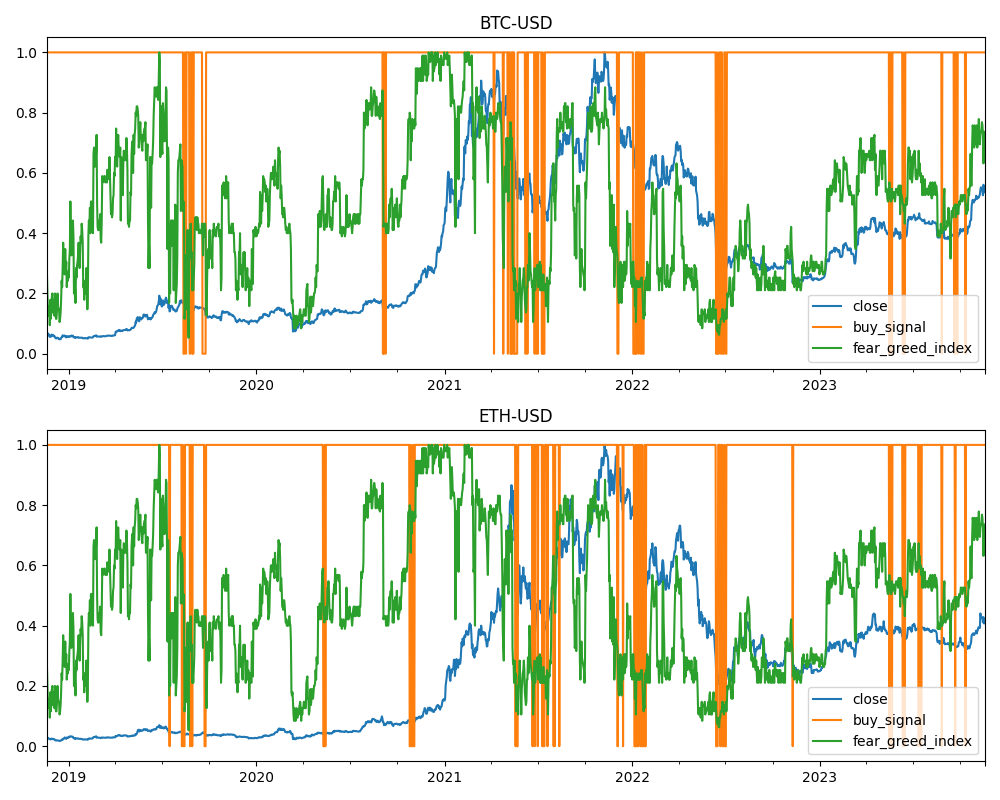

In [21]:
total_products = len(history_dfs)
fig, ax = plt.subplots(nrows=total_products, figsize=(10, 4 * total_products))
days = 90

for product_index, product_id in enumerate(product_ids):
    ax_index = ax if total_products <= 1 else ax[product_index]
    # history_dfs[product_id]["good_buy"] = history_dfs[product_id].fear_greed_index == history_dfs[product_id].fear_greed_index_min_30
    df_history1 = history_dfs[product_id][["close", f"close_min_{days}", f"close_max_{days}"]].copy()
    df_history2 = history_dfs[product_id][[f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}"]].copy()
    df_history3 = history_dfs[product_id][["fear_greed_index", f"fear_greed_index_min_{days}", f"fear_greed_index_max_{days}"]].copy()
    df_history4 = history_dfs[product_id][[f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"]].copy()
    
    df_history1_max = df_history1.to_numpy()[~np.isnan(df_history1.to_numpy())].max()
    df_history2_max = df_history2.to_numpy()[~np.isnan(df_history2.to_numpy())].max()
    df_history3_max = df_history3.to_numpy()[~np.isnan(df_history3.to_numpy())].max()
    df_history4_max = df_history4.to_numpy()[~np.isnan(df_history4.to_numpy())].max()
    
    for column in df_history1.columns:
        df_history1[column] = df_history1[column] / df_history1_max
    
    for column in df_history2.columns:
        df_history2[column] = df_history2[column] / df_history2_max
    
    for column in df_history3.columns:
        df_history3[column] = df_history3[column] / df_history3_max
    
    for column in df_history4.columns:
        df_history4[column] = df_history4[column] / df_history4_max
    
    df_history = df_history1.join(df_history2, how="outer").join(df_history3, how="outer").join(df_history4, how="outer")
    df_history["buy_signal"] = (
        (df_history.fear_greed_index > 0)
        & (df_history[f"close_gradient_{days}"] != df_history[f"close_gradient_min_{days}"])
    ).replace({True: 1, False: 0})
    
    df_history[[
        "close", "buy_signal",
        "fear_greed_index",
        # f"close_min_{days}", f"close_max_{days}",
        # f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}",
        # f"fear_greed_index_min_{days}", f"fear_greed_index_max_{days}",
        # f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"
        # "buy_signal", "sell_signal"
    ]].plot(ax=ax_index)
    
    ax_index.set_title(product_id)

plt.legend()
plt.tight_layout()
plt.show()

# df_history = history_dfs[product_id]
# display(df_history.corr().astype(str)[["period_max_close_pct_change"]])
# display(df_history.describe())

Total fee percentage: 0.8%
Start money: $2000
Min buy amount: $200
Max buy amount: $2000
End money: $11529.56
Pct earned: 476.478%
Total orders: 510
Avg pct earned per order: 0.934%
Total volume: $892282.66
Total days: 1825.0
Avg 30 day volume: $14667.66


,product_id,side,amount,coins,value,money,total_balance,fear_greed_index
timestamp,,,,,,,,
2019-05-17 00:00:00+00:00,BTC-USD,buy,1000.0,0.1356228447069333,7343.8955078125,1000.0,1992.0159999999996,65.0
2019-05-17 00:00:00+00:00,ETH-USD,buy,500.0,2.0429546609164766,243.76458740234375,500.0,1988.0239999999997,65.0
2019-05-18 00:00:00+00:00,BTC-USD,buy,250.0,0.0342446536713657,7271.2080078125,250.0,1957.5516959091515,67.0
2019-05-18 00:00:00+00:00,ETH-USD,buy,200.0,0.8491221237231968,234.59523010253906,50.0,1955.9548959091514,67.0
2019-05-25 00:00:00+00:00,ETH-USD,sell,725.1964456845938,2.89207678,251.75987243652344,775.1964456845938,2137.5904804372713,69.0
...,...,...,...,...,...,...,...,...
2023-10-14 00:00:00+00:00,BTC-USD,buy,708.75,0.026279603123463537,26861.70703125,708.768603007806,8800.908377140147,47.0
2023-10-14 00:00:00+00:00,ETH-USD,buy,354.38,0.22694803317629286,1555.2568359375,354.38860300780595,8798.079007220147,47.0
2023-10-15 00:00:00+00:00,ETH-USD,buy,200.0,0.1278504961097512,1558.06982421875,154.38860300780595,8855.18896823283,45.0


,product_id,side,total_orders
0,BTC-USD,buy,192
1,BTC-USD,sell,65
2,ETH-USD,buy,188
3,ETH-USD,sell,65


<Axes: xlabel='timestamp'>

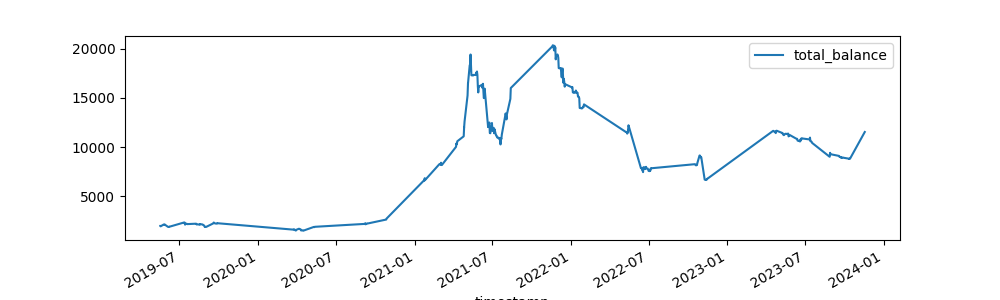

In [28]:
fee_pct = 0.8
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")

coins = {}
coins_hold = {}
min_hold = 0
max_hold = 0

for product_id in product_ids:
    coins[product_id] = 0
    coins_hold[product_id] = 0

money = 2000
start_money = money
print(f"Start money: ${start_money}")

min_buy_amount = 200
max_buy_amount = 2000
print(f"Min buy amount: ${min_buy_amount}")
print(f"Max buy amount: ${max_buy_amount}")

total_orders = 0
total_volume = 0
orders = []

total_products = len(product_ids)

# feat_greed_schedule = [
#     {'threshold': 0, 'factor': 1, 'action': 'buy'},
#     {'threshold': 30, 'factor': 1, 'action': 'buy'},
#     # {'threshold': 40, 'factor': 0.25, 'action': 'buy'},
#     # {'threshold': 60, 'factor': 0.25, 'action': 'sell'},
#     {'threshold': 70, 'factor': 1, 'action': 'sell'},
#     {'threshold': 100, 'factor': 1, 'action': 'sell'}
# ]

for product_id in product_ids:
    history_dfs[product_id]["product_id"] = product_id

df_final = pd.concat([history_dfs[product_id] for product_id in product_ids]).sort_index()

for index, row in df_final.iterrows():
    product_id = row.product_id

    def get_total_balance():
        total_balance = money

        for coin_product_id in product_ids:
            df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == coin_product_id)]

            if len(df_final_product_period) > 0:
                total_balance += coins[coin_product_id] * df_final_product_period.close.values[-1] * p_keep

        return total_balance

    def floor_value(x: float, precision: int):
        return np.true_divide(np.floor(x * 10**precision), 10**precision)

    condition_action = None
    condition_factor = None
    
    if (
        # row.fear_greed_index > 15
        # and row.fear_greed_index < 90
        # row.fear_greed_index == row.fear_greed_index_min_30
        # money > len(product_ids)
        
        # coins[product_id] * row.close < 1000
        # and row.fear_greed_index < row.fear_greed_index_max_120

        row.close_gradient_90 > row.close_gradient_min_90
        and row.fear_greed_index_gradient_90 > row.fear_greed_index_gradient_min_90
        
        and pd.to_datetime(index, utc=True) != pd.to_datetime(df_final.index.values[-1], utc=True)
    ):
        condition_action = "buy"
    else:
        condition_action = "sell"

    if condition_action == "buy":
        # condition_factor = (100 - row.fear_greed_index) / 100
        condition_factor = 1
        buy_amount = floor_value(money / len(product_ids) * condition_factor, 2)
        buy_amount = buy_amount if buy_amount >= min_buy_amount else min_buy_amount
        buy_amount = buy_amount if buy_amount <= max_buy_amount else max_buy_amount
        # buy_amount = 100

        if money >= buy_amount and buy_amount > 0:
            money -= buy_amount
            buy_coins = buy_amount / row.close * p_keep
            coins[product_id] += buy_coins
            total_orders += 1
            total_volume += buy_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "buy",
                    "amount": buy_amount,
                    "coins": buy_coins,
                    "value": row.close,
                    "money": money,
                    "total_balance": get_total_balance(),
                    "fear_greed_index": row.fear_greed_index,
                    # "fear_greed_index_min_30": row.fear_greed_index_min_30
                }
            )
    elif condition_action == "sell" and coins[product_id] > 0:
        # condition_factor = row.fear_greed_index / 100
        condition_factor = 1
        sell_coins = floor_value(coins[product_id] * condition_factor, 8)
        coins[product_id] = coins[product_id] - sell_coins
        sell_amount = sell_coins * row.close * p_keep
    
        if sell_amount > 0:
            total_orders += 1
            total_volume += sell_amount
            money += sell_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "sell",
                    "amount": sell_amount,
                    "coins": sell_coins,
                    "value": row.close,
                    "money": money,
                    "total_balance": get_total_balance(),
                    "fear_greed_index": row.fear_greed_index,
                    # "fear_greed_index_min_30": row.fear_greed_index_min_30
                }
            )

money += sum(
    [
        (coins[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
pct_earned = (money - start_money)/start_money*100
print(f"Pct earned: {pct_earned:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total orders: {total_orders}")
print(f"Avg pct earned per order: {pct_earned / total_orders:.3f}%")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders.astype(str))

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append({
            "product_id": product_id,
            "side": side,
            "total_orders": len(df_orders_product_side),
            # "avg_value": df_orders_product_side.value.sum() / len(df_orders_product_side)
        })

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)

df_orders[["total_balance"]].plot(figsize=(10, 3))
# df_orders_scaled = df_orders[["total_balance", "fear_greed_index", "fear_greed_index_min_30"]]
# df_orders_scaled = pd.DataFrame(scaler.fit_transform(df_orders_scaled.values), index=df_orders_scaled.index, columns=df_orders_scaled.columns).plot(figsize=(10, 3))

In [24]:
display(df_orders.loc[df_orders.side == "buy"].describe())
display(df_orders.loc[df_orders.side == "sell"].describe())
# df_orders.loc[(df_orders.index >= pd.Timestamp("2021-11-01", tz="UTC")) & (df_orders.index <= pd.Timestamp("2022-07-01", tz="UTC"))].tail(100)

,amount,coins,value,money,total_balance,fear_greed_index
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
mean,525.976163,0.216312,16270.602202,995.559214,4159.643568,33.569767
std,376.759851,0.375346,17366.941502,1265.478784,2147.795335,18.634436
min,100.000000,0.002003,166.727127,1.987052,977.977448,6.000000
25%,143.622500,0.016107,1901.912811,143.635752,2741.448058,20.000000
50%,415.670000,0.043370,7307.551758,415.678869,3927.027212,27.500000
75%,1000.000000,0.298044,30324.502930,1435.285520,5402.898393,47.000000
max,1000.000000,2.456133,60204.964844,6362.726100,10953.082709,79.000000


,amount,coins,value,money,total_balance,fear_greed_index
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,1594.179015,0.641476,15955.709787,2463.447739,3924.559244,36.574713
std,1408.682002,1.144801,17268.891750,1706.702591,2009.840971,18.845536
min,93.303245,0.002003,169.516739,125.179176,1113.634082,7.000000
25%,624.620031,0.047577,1848.117615,1194.017237,2733.064935,21.000000
50%,1255.338349,0.118698,9510.200195,2503.329882,3767.898167,31.000000
75%,2207.644998,0.843574,26954.985352,3457.784546,5073.738564,48.000000
max,7355.690714,6.307263,58232.316406,7362.726100,10365.508299,79.000000
